<a href="https://colab.research.google.com/github/MohiteYash/baby/blob/main/baby_Resnet_83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install necessary libraries if not already installed
!pip install librosa tensorflow keras numpy matplotlib

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Dataset Configuration
DATASET_PATH = "/content/drive/MyDrive/Baby_dataset/Baby_crying _Dataset"  # Check for spaces in path!
SAMPLE_RATE = 22050  # Standard sample rate for audio processing
N_MELS = 128  # Number of Mel filter banks
DURATION = 4  # Set to 4 seconds per audio sample
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
FIXED_FRAMES = 173  # Ensuring fixed spectrogram size

# Function to extract Mel-Spectrogram with a fixed shape
def extract_mel_spectrogram(audio, sr, fixed_frames=FIXED_FRAMES):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=N_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Fix shape by padding/truncating along the time axis
    mel_spec_db = librosa.util.fix_length(mel_spec_db, size=fixed_frames, axis=1)

    return mel_spec_db

# Data Augmentation Function
def augment_audio(audio, sr):
    # Time Stretching
    rate = np.random.uniform(0.8, 1.2)
    audio = librosa.effects.time_stretch(y=audio, rate=rate)

    # Pitch Shifting
    n_steps = np.random.randint(-2, 3)  # Include a wider range for variation
    audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

    # Adding Gaussian Noise
    noise = np.random.normal(0, 0.005, audio.shape)
    audio = audio + noise

    return audio

# Load dataset
def load_data(dataset_path):
    labels = []
    features = []

    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)

        if os.path.isdir(category_path):
            for file in os.listdir(category_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(category_path, file)

                    # Load audio file
                    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

                    # Apply Data Augmentation
                    augmented_audio = augment_audio(audio, sr)

                    # Convert to Mel-Spectrogram
                    mel_spec = extract_mel_spectrogram(audio, sr)
                    mel_spec_augmented = extract_mel_spectrogram(augmented_audio, sr)

                    # Append data
                    features.append(mel_spec)
                    features.append(mel_spec_augmented)
                    labels.append(category)
                    labels.append(category)

    return np.array(features, dtype=np.float32), np.array(labels)

# Load dataset
X, y = load_data(DATASET_PATH)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

# Reshape X for CNN (Adding channel dimension)
X = X.reshape(X.shape[0], N_MELS, FIXED_FRAMES, 1)  # Shape: (samples, height, width, channels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded successfully! X shape: {X.shape}, y shape: {y.shape}")


Dataset loaded successfully! X shape: (914, 128, 173, 1), y shape: (914, 5)


In [ ]:
import cv2
X_train_resized = np.array([cv2.resize(img, (128, 128)) for img in X_train])
X_test_resized = np.array([cv2.resize(img, (128, 128)) for img in X_test])

X_train = X_train_resized.reshape(X_train_resized.shape[0], 128, 128, 1)
X_test = X_test_resized.reshape(X_test_resized.shape[0], 128, 128, 1)


In [ ]:
# Load Pretrained ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Convert grayscale to RGB by repeating channels
from tensorflow.keras.layers import Input, Conv2D
input_layer = Input(shape=(128, 128, 1))
x = Conv2D(3, (3, 3), padding="same", activation="relu")(input_layer)

# Connect to ResNet50
x = base_model(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(y_train.shape[1], activation="softmax")(x)  # Output Layer

# Compile Model
model = Model(inputs=input_layer, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)

# Train Model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 310s 21s/step - accuracy: 0.2460 - loss: 2.5041 - val_accuracy: 0.0437 - val_loss: 2.9564 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 248s 20s/step - accuracy: 0.4671 - loss: 1.6021 - val_accuracy: 0.1311 - val_loss: 2.9708 - learning_rate: 1.0000e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 273s 21s/step - accuracy: 0.5878 - loss: 1.1897 - val_accuracy: 0.2077 - val_loss: 2.6657 - learning_rate: 1.0000e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 253s 20s/step - accuracy: 0.7110 - loss: 0.8485 - val_accuracy: 0.2514 - val_loss: 2.9980 - learning_rate: 1.0000e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 260s 20s/step - accuracy: 0.8958 - loss: 0.4177 - val_accuracy: 0.3552 - val_loss: 2.6831 - learning_rate: 1.0000e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 266s 20s/step - accuracy: 0.9462 - loss: 0.2518 - val_accuracy: 0.4426 - val_loss: 2.5611 - learning_rate: 1.0000e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 263s 20s/step - accuracy: 

In [ ]:
# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 985ms/step - accuracy: 0.8218 - loss: 1.0253
Test Accuracy: 83.61%


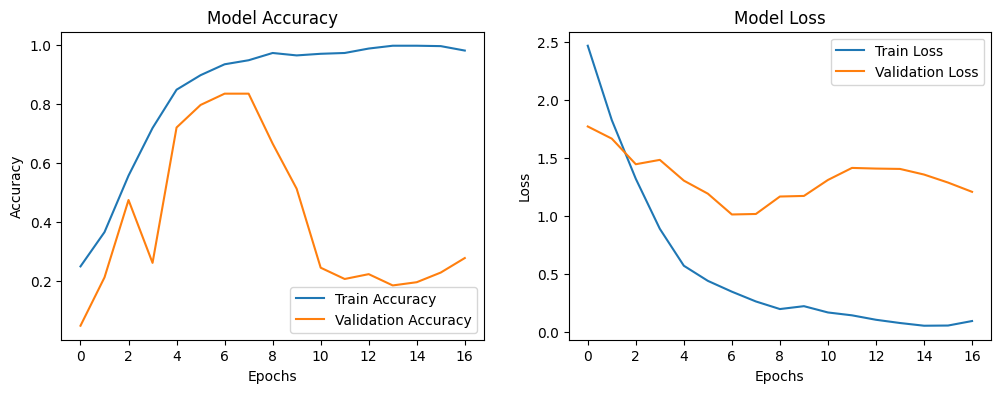

In [ ]:
# Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

plt.show()


In [ ]:
# Print final validation accuracy from training history
val_acc = max(history.history["val_accuracy"])  # Get the highest validation accuracy
print(f"Best Validation Accuracy: {val_acc * 100:.2f}%")


Best Validation Accuracy: 83.61%


In [ ]:
# Save the model in HDF5 format
model.save("baby_cry_classifier_resnet_83.h5")



print("Model saved successfully!")


Model saved successfully!


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 985ms/step


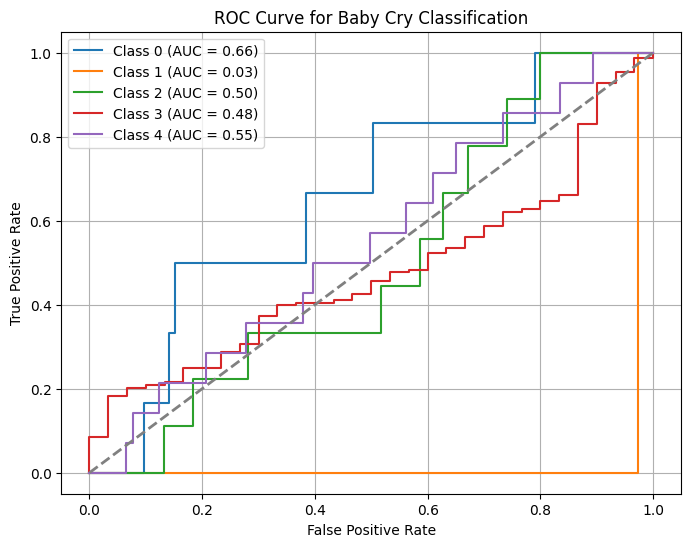

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions (probabilities)
y_pred_prob = model.predict(X_test)

# If multi-class, use One-vs-Rest strategy
num_classes = y_test.shape[1]  # Assuming one-hot encoded labels

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Baby Cry Classification")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Compute AUC for all classes
auc_score = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
print(f"Overall AUC Score: {auc_score:.2f}")


Overall AUC Score: 0.44
